## SSAC - Exploration 12 - DC GAN : cifar 10

---
### STEP 1. 데이터셋 구성하기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)


    학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
    로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
    tf.data.Dataset 모듈의 fromtensorslices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다.


In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 정규화
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


---
#### 로드 데이터 시각화

In [5]:
train_x.shape

(50000, 32, 32, 3)

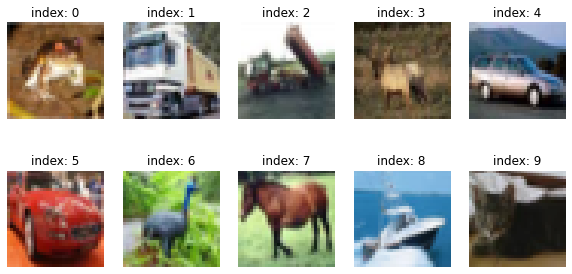

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    sample = (train_x[i]+1)/2
    plt.imshow(sample.reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

---
#### 미니배치 데이터 셋 구성

In [7]:
# 텐서플로우 dataset으로 준비하기
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

---
### STEP 2. 생성자 모델 구현하기

---
#### 생성자 모델 구현 함수 작성

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0

---
#### 노이즈를 넣어 랜덤 이미지 생성해 보기

In [11]:
# 샘플 노이즈 벡터 만들기
noise = tf.random.normal([1, 100])

In [12]:
# 작동 확인
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

+ 생성된 이미지의 크기는 cifar10 데이터와 동일한 32,32 사이즈의 3채널 이미지 인 것을 확인할 수 있다.

In [13]:
generated_image = (generated_image + 1) / 2.0

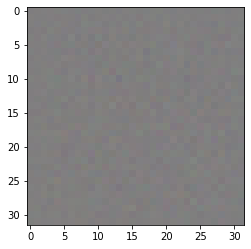

In [14]:
plt.imshow(generated_image[0])
plt.show()

+ 회색 노이즈 이미지가 생성된 것을 확인할 수 있다.

---
### STEP 3. 판별자 모델 구현하기

---
### 판별자 모델 구현함수

In [15]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [16]:
# 판별모델 생성
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [17]:
# 아까 만든 이미지를 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.08540489]], dtype=float32)>

---
### STEP 4. 손실함수와 최적화 함수 구현하기

---
#### 생성자와 편발자의 손실함수 구현

In [18]:
# 손실함수 받아오기
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [19]:
# generator loss 구현하기 만들어낸 이미지의 판별자 출력값과 그 출력값과 동일한 사이즈의 모든 원소가 1인 데이터 와의 비교
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
# discriminator loss 구현하기 : 만들어낸 이미지 출력값은 0행렬과, 진짜 이미지 출력값은 1행렬과 비교
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

---
#### 이미지 판별 정확도 계산 함수 구현

In [21]:
# 진짜를 진짜로 판별한 정확도와 가짜를 가짜로 판별한 정확도 계산 : 이상적인 결과는 둘 다 0.5에 가까워 지는 것.
# 판별을 잘해서 가짜 판별 정확도가 1.0에 가까우면 생성자가 판별자를 잘 속이지 못하는 것
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

---
### 생성자, 판별자 최적화 함수 정의

In [22]:
# 생성 판별 최적화는 adam 사용 : 두 모델 따로 학습하므로 최적화를 따로 만들어줘야 한다
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

---
### STEP 5. 훈련과정 상세 기능 구현하기

---
### train_step() 함수

In [23]:
# 데코레이터 사용된 함수에 입력된 입력은 tf의 graph 노드가 될수 있는 타입으로 자동 변환됨

@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

---
#### 16개 seed 입력으로 훈련 과정 중에 생성한 이미지 시각화 하는 함수 구현

In [24]:
# 매번 학습이 어떻게 진행되어가는지 보기 위해 생성자 생성 샘플을 16장씩 뽑아 확인하기
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [25]:
# 학습 현황을 볼 수 있는 함수 : 고정한 seed의 결과물이 어떻게 되는지 확인할 수 있다.
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        sample = (predictions[i]+1)/2
        plt.imshow(sample)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

---
#### 훈련 epoch마다 생성자 판별자의 loss, 생성자 판별자의 accuracy를 그래프로 시각화 하는 함수 구현

In [26]:
# 학습 과정 중 loss history 볼 수 있는 함수
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

---
#### checkpoint 모듈 생성

In [27]:
# 체크포인트 만들기
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "cp")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

---
### STEP 6. 학습 과정 진행하기

In [28]:
# 만든것 합치기
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [29]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

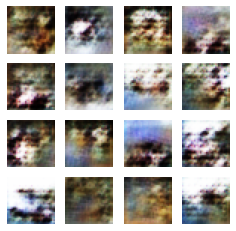

Time for training : 1765 sec


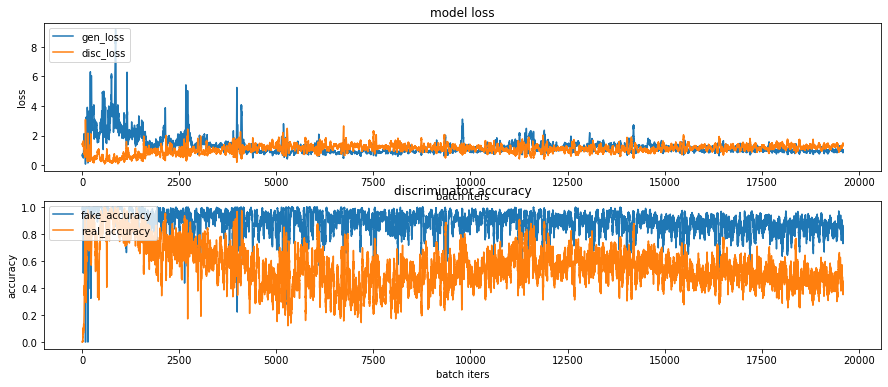

In [30]:
# 학습시작
train(train_dataset, EPOCHS, save_every)

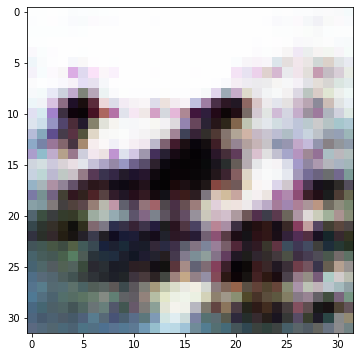

In [31]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])

plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [32]:
# 아까 만든 이미지를 주었을 때 결과 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5460282]], dtype=float32)>

In [1]:
'''
save_every = 5
EPOCHS = 100
train(train_dataset, EPOCHS, save_every)
'''

'\nsave_every = 5\nEPOCHS = 100\ntrain(train_dataset, EPOCHS, save_every)\n'

In [33]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan_1.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

#### 생성 이미지 
![cifar10gif](./images/cifar10_dcga

---
### STEP 7. (optional) GAN 훈련 과정 개선하기

In [38]:
tf.ones_like(decision)-0.1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9]], dtype=float32)>

In [40]:
tf.zeros_like(decision)+0.1

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.1]], dtype=float32)>

---
루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.
평가문항	상세기준

1. GAN의 두 모델 구조를 통해 이미지를 성공적으로 생성하였다.
	오브젝트 종류를 육안으로 구별할 수 있을 만한 이미지를 생성하였다.

2. 생성 이미지 시각화 및 학습 그래프를 통해 GAN 학습이 바르게 진행되었음을 입증하였다.
	gif를 통해 생성이미지 품질이 서서히 향상되는 것과, fake accuracy가 추세적으로 0.5를 향해 하향하고 있음을 확인하였다.

3. 추가적인 GAN 모델구조 혹은 학습과정 개선 아이디어를 제안하고 이를 적용하였다.
	제출 아이디어를 제출 프로젝트에 반영하고, 그 결과가 아이디어 적용 이전보다 향상되었음을 시각적으로 입증하였다.